# DLinear Implemented

The architecture has the following distinctive features:
* Uses Autoformmer's trend and seasonality decomposition.
* Simple linear layers for trend and seasonality component.

Inspiration from: 
* https://github.com/Nixtla/neuralforecast/blob/main/nbs/models.dlinear.ipynb
* https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Auxiliary Functions

In [73]:
class MovingAvg(nn.Module): 
  """ Moving average module to hightlight the trend of timeseries """
  def __init__(self, kernel_size, stride):
      super(MovingAvg, self).__init__()
      self.kernel_size = kernel_size
      self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

  def forward(self, x):
      # padding on the both ends of time series
      front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
      end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
      x = torch.cat([front, x, end], dim=1)
      x = self.avg(x.permute(0, 2, 1))
      x = x.permute(0, 2, 1)
      return x

class SeriesDecomp(nn.Module): 
  """  Series Decomposition module """
  def __init__(self, kernal_size):
    super(SeriesDecomp, self).__init__()
    self.MovingAvg = MovingAvg(kernal_size, stride=1)
  def forward(self, x):
    moving_mean = self.MovingAvg(x)
    res = x - moving_mean
    return res, moving_mean

# DLinear Model

In [74]:
class series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class Model(nn.Module):
    """
    Decomposition-Linear
    """

    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = SeriesDecomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(
                    nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(
                    nn.Linear(self.seq_len, self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(
            0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(
                1), self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(
                1), self.pred_len], dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](
                    seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](
                    trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0, 2,1) # to [Batch, Output length, Channel]

## Wrap Model in a Pytorch Lightning Module

In [79]:
class DLinearLightning(pl.LightningModule):
    def __init__(self, configs):
        super(DLinearLightning, self).__init__()
        self.model = Model(configs)
        self.loss_fn = nn.MSELoss()  # Define the loss function here

    def forward(self, x):
        return self.model(x)

    # def training_step(self, batch):
    #     x, y = batch
    #     y_hat = self(x)
    #     loss = self.loss_fn(y_hat, y)
    #     self.log('train_loss', loss)
    #     return loss

    def training_step(self, batch): 
        x, y = batch
        ## Use Autocast for mixed precision training
        with torch.autocast("mps", dtype=torch.float16):
            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss 

    def predict_step(self, batch: int = 0):
        # Unpack the batch; ignore y if not needed for prediction.
        x, _ = batch  
        y_hat = self(x)  # Now x is the input tensor as expected
        return y_hat

    def validation_step(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Load, Preprocessing, Create Dataset from data 

In [3]:
scaler = StandardScaler()


def load_preprocessing_data():
    df = pd.read_csv('ConsumptionIndustry.csv', delimiter=';', decimal=',')
    # convert to datetime and set index if needed
    df['HourDK'] = pd.to_datetime(df['HourDK'], format='%Y-%m-%d %H:%M:%S')
    df = df.set_index('HourDK')
    # drop unnecessary columns
    df = df.drop(columns=['HourUTC', 'Branche', 'MunicipalityNo'])

    print(df.isnull().sum())

    # Ensure the values are 2D: shape (n_samples, 1)
    data = df.values
    data = df.values.astype('float32')

    # Normalize the data
    data = scaler.fit_transform(data)

    if data.ndim == 1:
        data = data.reshape(-1, 1)
    return data



class ElectricityDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        # If data is a DataFrame, convert to 2D NumPy array here.
        if hasattr(data, "values"):
            data = data.values
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len

    def __getitem__(self, idx):
        # Now slicing will return arrays with shape (seq_len, 1)
        x = self.data[idx: idx + self.seq_len]      # Expected shape: (96, 1)
        y = self.data[idx + self.seq_len: idx + self.seq_len +
                      self.pred_len]  # Expected shape: (24, 1)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

  
# load data
data = load_preprocessing_data()

print(data)

# define sequence length and prediction length
seq_len = 336  # 4 days
pred_len = 24 # 1 day

# split the data into training and validation and test set
total_samples = len(data)
train_split = int(total_samples * 0.8)
val_split = int(total_samples * 0.9)

train_dataset = ElectricityDataset(data[:train_split], seq_len, pred_len)
val_dataset = ElectricityDataset(data[train_split:val_split], seq_len, pred_len)
test_dataset = ElectricityDataset(data[val_split:], seq_len, pred_len)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

ConsumptionkWh    0
dtype: int64
[[ 0.47661787]
 [ 0.21340512]
 [-0.10261467]
 ...
 [ 1.1427866 ]
 [ 0.7510257 ]
 [ 0.39180878]]


# Train and predict on the model 

## Full precesion

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | Model   | 16.2 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
16.2 K    Trainable params
0         Non-trainable params
16.2 K    Total params
0.065     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/testing_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/testing_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
/opt/homebrew/Caskroom/miniconda/base/envs/testing_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE: 2655.62744140625, MAE: 1899.1568603515625, MAPE: 0.058595042675733566


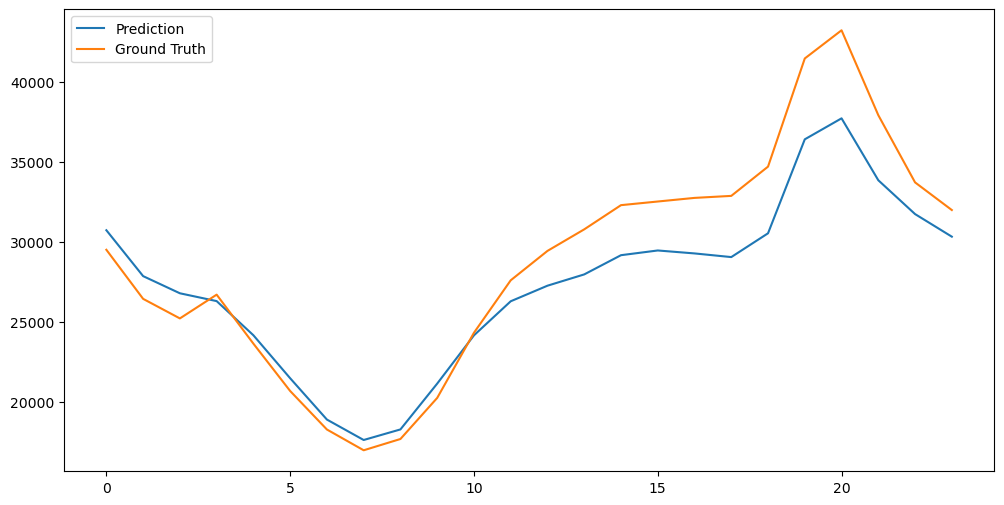

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error


class config:
  def __init__(self):
    self.seq_len = 336
    self.pred_len = 24
    self.kernal_size = 25 # 25 hours
    self.individual = False # if True, decompose each channel individually
    self.channels = 1 # number of channels in the input data
    self.enc_in = 1 # number of input features  (1 for univariate time series)


if __name__ == '__main__':
  configs = config()

  # Instantiate the LightningModule.
  model = DLinearLightning(configs)

  # Create the Trainer
  trainer = Trainer(max_epochs=100, accelerator='mps')

  print(train_loader)

  # Train the model ⚡
  trainer.fit(model, train_loader, val_loader)

  # After prediction:
predictions = trainer.predict(model, test_loader)
preds = torch.cat(predictions, dim=0)  # shape: (N, pred_len, 1)
preds = preds.squeeze(-1)              # shape: (N, pred_len)

# Extract ground truth from test_loader
all_y = []
for _, y in test_loader:
    all_y.append(y)
all_y = torch.cat(all_y, dim=0)         # shape: (N, pred_len, 1)
all_y = all_y.squeeze(-1)               # shape: (N, pred_len)

# Convert to NumPy arrays
preds_np = preds.cpu().numpy()
all_y_np = all_y.cpu().numpy()

# Inverse scaling
preds_np = scaler.inverse_transform(preds_np)
all_y_np = scaler.inverse_transform(all_y_np)

# Calculate metrics
rmse = root_mean_squared_error(all_y_np, preds_np)
mae = mean_absolute_error(all_y_np, preds_np)
mape = mean_absolute_percentage_error(all_y_np, preds_np)

print(f'RMSE: {rmse}, MAE: {mae}, MAPE: {mape}')

# Optionally, plot the results for a single example:
import matplotlib.pyplot as plt

# Let's plot the predictions and ground truth for the first sample:
plt.figure(figsize=(12, 6))
plt.plot(preds_np[0], label='Prediction')
plt.plot(all_y_np[0], label='Ground Truth')
plt.legend()
plt.show()

## Mixed Precession 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | Model   | 16.2 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
16.2 K    Trainable params
0         Non-trainable params
16.2 K    Total params
0.065     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/testing_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/testing_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
/opt/homebrew/Caskroom/miniconda/base/envs/testing_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE: 2659.010986328125, MAE: 1888.1888427734375, MAPE: 0.058195214718580246


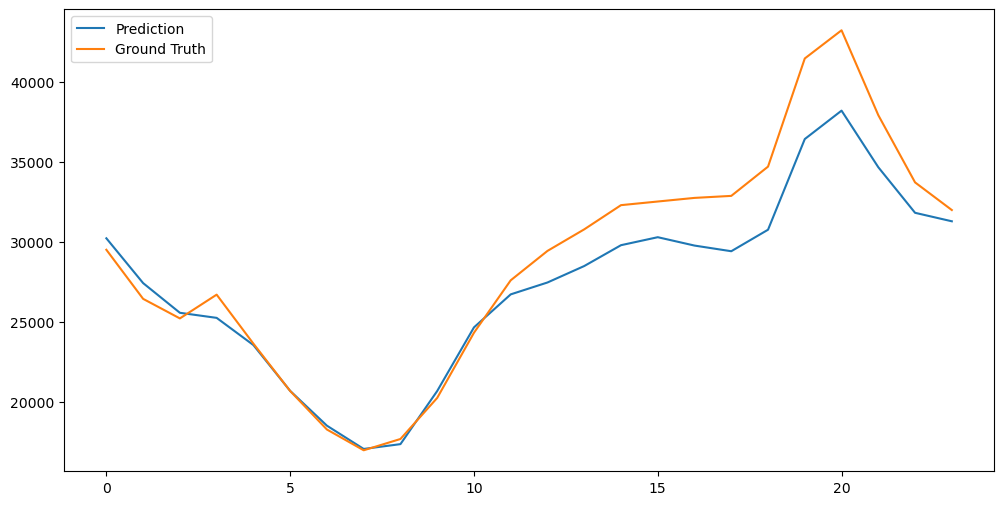

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error


class config:
  def __init__(self):
    self.seq_len = 336
    self.pred_len = 24
    self.kernal_size = 25  # 25 hours
    self.individual = False  # if True, decompose each channel individually
    self.channels = 1  # number of channels in the input data
    self.enc_in = 1  # number of input features  (1 for univariate time series)


if __name__ == '__main__':
  configs = config()

  # Instantiate the LightningModule.
  model = DLinearLightning(configs)

  # Create the Trainer
  trainer = Trainer(max_epochs=100, accelerator='mps')

  print(train_loader)

  # Train the model ⚡
  trainer.fit(model, train_loader, val_loader)

  # After prediction:
  predictions = trainer.predict(model, test_loader)
  preds = torch.cat(predictions, dim=0)  # shape: (N, pred_len, 1)
  preds = preds.squeeze(-1)              # shape: (N, pred_len)

  # Extract ground truth from test_loader
  all_y = []
  for _, y in test_loader:
      all_y.append(y)
  all_y = torch.cat(all_y, dim=0)         # shape: (N, pred_len, 1)
  all_y = all_y.squeeze(-1)               # shape: (N, pred_len)

  # Convert to NumPy arrays
  preds_np = preds.cpu().numpy()
  all_y_np = all_y.cpu().numpy()

  # Inverse scaling
  preds_np = scaler.inverse_transform(preds_np)
  all_y_np = scaler.inverse_transform(all_y_np)

  # Calculate metrics
  rmse = root_mean_squared_error(all_y_np, preds_np)
  mae = mean_absolute_error(all_y_np, preds_np)
  mape = mean_absolute_percentage_error(all_y_np, preds_np)

  print(f'RMSE: {rmse}, MAE: {mae}, MAPE: {mape}')

  # Optionally, plot the results for a single example:

  # Let's plot the predictions and ground truth for the first sample:
  plt.figure(figsize=(12, 6))
  plt.plot(preds_np[0], label='Prediction')
  plt.plot(all_y_np[0], label='Ground Truth')
  plt.legend()
  plt.show()